# Description

This notebook is used to process and evalutate the initial universe of generated smiles, and then retain the network applying techniques and principles from both transfer learning and genetic algorithms to increasingly improve molecule generation for the specific task of binding with cornovirus protease.

## First process initial generated smiles for PyRx analysis 

In [8]:
import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors
import random
import numpy as np
import rdkit.Chem.PropertyMol

In [9]:
# load gen0_smiles.smi as gen0_table
# generation/gen0_smiles.smi
gen0_table = pd.read_csv('./generations/gen0_smiles.smi',sep=',', header=None)
gen0 = list(gen0_table[0])[0:10000]
len(gen0)

9703

In [10]:
def validate_mols(list_of_smiles):
    """
    :param list_of_smiles: python list of smiles
    """
    valid_mols = []
    for smi in list_of_smiles:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            valid_mols.append(mol)
    return valid_mols

def convert_mols_to_smiles(list_of_mols):
    valid_smiles = [Chem.MolToSmiles(mol) for mol in list_of_mols]
    return valid_smiles

In [11]:
gen0_mols = validate_mols(gen0)
len(gen0_mols)

9703

### Molecular Fingerprint
Molecular fingerprints are a way of encoding the structure of a molecule. The most common type of fingerprint is a series of binary digits (bits) that represent the presence or absence of particular substructures in the molecule. Comparing fingerprints allows you to determine the similarity between two molecules, to find matches to a query substructure, etc.

### Tanimoto Analysis
One commonly used algorithm to calculate the similarity is the Tanimoto coefficient. In the Tanimoto Algorithm A and B are sets of fingerprint bits on in the fingerprints of molecule A and molecule B. AB is the set of common bits of fingerprints of both molecule A and B. The Tanimoto coefficient ranges from 0 when the fingerprints have no bits in common, to 1 when the fingerprints are identical.

In [12]:
def initialize_generation_from_mols(list_of_mols,desired_length): 
    '''
    Intakes a list of smiles, randomly shuffles them, then adds first thirty,
    then sets a max-similarity threshold between any new molecule and existing list
    and iteratively increases the treshold until X components are picked to ensure diveristy
    '''
    assert desired_length >30
    random.shuffle(list_of_mols)
    random.shuffle(list_of_mols)
    
    # Prepare fingerprints for similarity calcs
    mol_fingerprints = []
    for mol in list_of_mols:
        mol_fingerprints.append(Chem.RDKFingerprint(mol))
    
    selected_mols = list_of_mols[0:30]
    selected_fingerprints = mol_fingerprints[0:30]
    remaining_mols = list_of_mols[30:]
    remaining_fingerprints = mol_fingerprints[30:]
    
    # Start with 0.05 as treshold
    similarity_threshold = .05   
    while len(selected_mols) < desired_length:
        for fingerprint, mol in zip(remaining_fingerprints, remaining_mols):
            max_similarity = np.max(DataStructs.BulkTanimotoSimilarity(fingerprint,selected_fingerprints))
            if (max_similarity <= similarity_threshold) and (max_similarity < 1):
                selected_fingerprints.append(fingerprint)
                selected_mols.append(mol)
        print("Completed loop with threshold at: ", similarity_threshold, ". Length is currently: ", len(selected_mols))
        similarity_threshold += .05
    return selected_mols

In [13]:
# Select 1000 molecule based on tanimota similarity

gen0_mols = initialize_generation_from_mols(gen0_mols,1000)

Completed loop with threshold at:  0.05 . Length is currently:  30
Completed loop with threshold at:  0.1 . Length is currently:  30
Completed loop with threshold at:  0.15000000000000002 . Length is currently:  33
Completed loop with threshold at:  0.2 . Length is currently:  42
Completed loop with threshold at:  0.25 . Length is currently:  75
Completed loop with threshold at:  0.3 . Length is currently:  213
Completed loop with threshold at:  0.35 . Length is currently:  518
Completed loop with threshold at:  0.39999999999999997 . Length is currently:  1119


In [14]:
# Questions: Where is this master_results_table.csv comes from (maybe from nothing)
# generations/master_results_table.csv

master_table = pd.read_csv('./generations/master_results_table.csv',sep=',')

In [15]:
def iterate_alpha(alpha_code):
    '''
    Certainly not opimized and not strictly necessary, but in the PyRx GUI
    molecule names would sort oddly when in any numeric order, so ordering
    molcules by a four letter code. This function iterates the four letter code.
    '''
    numbers = []
    for letter in alpha_code:
        number = ord(letter)
        numbers.append(number)
    
    if numbers[3]+1 > 90:
        if numbers[2]+1 > 90:
            if numbers[1]+1 > 90:
                if numbers[0]+1 > 90:
                    raise ValueError('Too long for alpha code')
                else:
                    numbers[3] = 65
                    numbers[2] = 65
                    numbers[1] = 65
                    numbers[0] = numbers[0] + 1
            else:
                numbers[3] = 65
                numbers[2] = 65
                numbers[1] = numbers[1] + 1
        else:
            numbers[3] = 65
            numbers[2] = numbers[2] + 1
    else:
        numbers[3] = numbers[3] + 1
    

    new_code = ""
    for number in numbers:
        new_code += chr(number)
    return new_code
iterate_alpha('AAAA')

'AAAB'

In [16]:
master_table

,id,gen,smile,source,score
0,AAAC,0,CC(=O)Nc1ccc(S(=O)(=O)Nc2ccc(C)c(C)c2)cc1,training,99.9
1,AAAD,0,CCOC(=O)C1=C(C(=O)OCC)C(c2cccc(Cl)c2)NC(=O)N1,generated,99.9
2,AAAE,0,NC(=O)c1ccc(NC(=O)C(CC(=O)O)NC(=O)c2cc(-c3cccc...,generated,99.9
3,AAAF,0,COC(=O)c1ccc2c(c1)N(C(=O)c1ccc(C)cc1)CC(C)(C)O2,generated,99.9
4,AAAG,0,Cc1ccc(C(=O)Nc2ccc(C(=O)N3CCOCC3)cc2)cc1,training,99.9
...,...,...,...,...,...
2280,BBFT,0,CCCC1(CCc2ccccc2)CC(O)=C(C(CC)c2cccc(NS(=O)(=O...,manual,99.9
2281,BBFU,0,O=C1Nc2ccc(Cl)cc2C(C#CC2CC2)(C(F)(F)F)O1,manual,99.9
2282,BBFV,0,CC(C)(C)NC(=O)C1CN(Cc2cccnc2)CCN1CC(O)CC(Cc1cc...,manual,99.9
2283,BBFW,0,CCOP(=O)(COc1ccc(CC(NC(=O)OC2COC3OCCC23)C(O)CN...,manual,99.9


In [17]:
def append_to_tracking_table(master_table,mols_to_append, source, generation):
    '''
    This function is use to apend the mols to master table.
    
    :param master_table: pandas dataframe table
    :param mols_to_append: molecule to append to the table
    :param source: python string on how the molecule comes from ex.'generated', 'local_ga'
    :generation: which generation of the genetic algorithm
    
    :return pandas.DataFrame of molecule, mols_to_export(type:sdkit)
    '''
    # Assign IDs for tracking to each mol, and assign a pandas table entry for each
    mols_to_export = []
    rows_list = []
    
    master_table_gen = master_table[master_table['gen'] == generation]
    if master_table_gen.shape[0] == 0:
        id_code = 'AAAA'
    else:
        master_table_gen_ids = master_table_gen.sort_values('id', ascending=True)
        master_table_gen_max_id = master_table_gen_ids.tail(1)
        key = master_table_gen_max_id['id'].keys()[0]
        id_code = iterate_alpha(str(master_table_gen_max_id['id'][key])) # Call function iterate_alpha
        
    training_data = pd.read_csv('./datasets/all_smiles_clean.smi', header=None)
    training_set = set(list(training_data[0]))
    
    for mol in mols_to_append:
        pm = Chem.PropertyMol.PropertyMol(mol)
        title = 'id' + str(id_code) + 'gen'+ str(generation)
        # print(title)
        
        # Enables for tracking which molecule is which in PyRx GUI and PyRx results export
        pm.SetProp('Title', title)
        mols_to_export.append(pm)

        #And track in pandas
        mol_dict = {}
        mol_dict['id'] = id_code
        mol_dict['gen'] = generation
        smile = Chem.MolToSmiles(mol)
        assert type(smile) == type('string')
        mol_dict['smile'] = smile

        if (source!= 'hiv' and source != 'manual' and source != 'baseline') and (smile in training_set):
            mol_dict['source'] = 'training'
        else:
            mol_dict['source'] = source
        mol_dict['score'] = 99.9

        rows_list.append(mol_dict)
        id_code = iterate_alpha(id_code) # Call function iterate_alpha
        
    df = pd.DataFrame(rows_list)
    return df, mols_to_export

In [18]:
new_mols_to_test = append_to_tracking_table(master_table,gen0_mols, 'generated', 0)
mols_for_pd = new_mols_to_test[0]
mols_for_export = new_mols_to_test[1]
master_table = master_table.append(mols_for_pd)
len(mols_for_export)

1119

In [19]:
# dropping ALL duplicate values 
master_table.drop_duplicates(subset ="smile", keep = False, inplace = True) 

In [20]:
master_table

,id,gen,smile,source,score
0,AAAC,0,CC(=O)Nc1ccc(S(=O)(=O)Nc2ccc(C)c(C)c2)cc1,training,99.9
1,AAAD,0,CCOC(=O)C1=C(C(=O)OCC)C(c2cccc(Cl)c2)NC(=O)N1,generated,99.9
2,AAAE,0,NC(=O)c1ccc(NC(=O)C(CC(=O)O)NC(=O)c2cc(-c3cccc...,generated,99.9
3,AAAF,0,COC(=O)c1ccc2c(c1)N(C(=O)c1ccc(C)cc1)CC(C)(C)O2,generated,99.9
4,AAAG,0,Cc1ccc(C(=O)Nc2ccc(C(=O)N3CCOCC3)cc2)cc1,training,99.9
...,...,...,...,...,...
1113,BCWT,0,O=c1nc(N2CCOCC2)oc2cc3c(cc12)OCCO3,generated,99.9
1114,BCWU,0,Cc1ccc(-c2nc3ccccc3c3cc(C)ccc23)c(C)c1,generated,99.9
1115,BCWV,0,COc1ccc(C=Cc2nc(SCc3ccccc3)n[nH]2)cc1OC,generated,99.9
1117,BCWX,0,O=C(O)c1ccc2c(c1)[nH]c1ccc(NC(=O)c3ccccc3)cc12,generated,99.9


#### Append the results to master table.csv

In [14]:
# Save the result to 'generations/master_results_table.csv'

master_table = master_table.reset_index(drop=True)
master_table.to_csv(r'./generations/master_results_table.csv', index=False)

#### Manually Append HIV drug and few others drug to the master table

In [15]:
# Add HIV inhibitors manually into the table
hiv_smiles = pd.read_csv('./datasets/hiv_inhibitors_cleaned.smi',sep=',', header=None)
hiv_smiles = list(hiv_smiles[0])
hiv_mols = validate_mols(hiv_smiles)

master_table = pd.read_csv('./generations/master_results_table.csv',sep=',')
new_mols_to_test = append_to_tracking_table(master_table,hiv_mols, 'hiv', 0)
mols_for_pd = new_mols_to_test[0]
mols_for_export = mols_for_export + new_mols_to_test[1]

master_table = master_table.append(mols_for_pd)
master_table = master_table.reset_index(drop=True)
master_table.to_csv(r'./generations/master_results_table.csv', index=False)

In [16]:
# Add a few other smiles manually into the table ("control group" of training smiles)
manual_smiles = pd.read_csv('./datasets/manual_testing_cleaned.smi',sep=',', header=None)
manual_smiles = list(manual_smiles[0])
manual_mols = validate_mols(hiv_smiles)

master_table = pd.read_csv('./generations/master_results_table.csv',sep=',')
new_mols_to_test = append_to_tracking_table(master_table,manual_mols, 'manual', 0)
mols_for_pd = new_mols_to_test[0]
mols_for_export = mols_for_export + new_mols_to_test[1]

master_table = master_table.append(mols_for_pd)
master_table = master_table.reset_index(drop=True)
master_table.to_csv(r'./generations/master_results_table.csv', index=False)

In [21]:
def write_gen_to_sdf(mols_for_export, generation, batch_size):
    '''
    Function to convert current generation of molecule to structure data files(SDF). To load in the PyRX to evaluate.
    
    :param mols_for_export: molecule to export (mol)
    :param generation: generation of the Global GA
    :param batch_size: maximum size of a single sdf files
    
    :return: ligands in sdf file format
    
    :output files: 
    If the incoming mol is more than batch size:
        generations/gen(i)_batch_(i+1).sdf
    Else:
        generations/gen(i).sdf
    '''
    if len(mols_for_export) > batch_size:
        batches = (len(mols_for_export) // 1000)+1
        for i in range(0,batches):
            batch_to_export = mols_for_export[i*batch_size:(i+1)*batch_size]
            w = Chem.SDWriter('./generations/gen' +str(generation) + '_batch_' + str(i+1) + '.sdf')
            for m in batch_to_export: w.write(m)
    else:
        w = Chem.SDWriter('./generations/gen' +str(generation) + '.sdf')
        for m in mols_for_export:
            w.write(m)
    
    # Noticed an issue where the very last line item of an sdf write is not written correctly until another arbitary write is made
    w = Chem.SDWriter('./generations/junk/test.sdf')
    w.write(m)
    
    return mols_for_export

In [18]:
write_gen_to_sdf(mols_for_export, 0, 2000)
print('ok')

ok


## NOW GO TO PyRx: Analyze the SDF file and create a csv of binding score results (End of Generation 0)

Saved the results in csv:

generations/results/master_results_table_gen(i).csv


## Afterwards, process binding simulation results to 'evolve' the molecules

In [22]:
'''This number must be MANUALLY iterated each generation. I did not write the entire process into a smooth function or loop but that would be the next steps.''' 
GLOBAL_GENERATION = 12

In [23]:
# Read the csv result analyzed in previous generation
# './generations/master_results_table_gen(i-1).csv'
master_table = pd.read_csv('./generations/master_results_table_gen' + str(GLOBAL_GENERATION-1) + '.csv',sep=',')
master_table.tail()

,id,gen,smile,source,weight,logp,score
12092,ABAM,0,CCOC(=O)C1CCN(C(=O)c2cc(-c3c(C)noc3C)c(C)s2)CC1,generated,376.478,3.74366,99.9
12093,ABOU,6,COC1C=CC(C(=O)N2CCC(c3ccc(O)cc3)C2)C1,generated,287.359,2.29920,99.9
12094,ABOV,6,CC(CO)C(=O)Nc1nnnnn1,generated,184.159,-1.77150,99.9
12095,ABOA,6,COC1=CC=C(C2CC2)CC1CC1=CC=CC1,generated,228.335,4.14940,99.9
12096,AAAV,1,CC(C)(C)NC(=O)C1CN(Cc2ccccc2Cl)CCN1CC(O)CC(Cc1...,generated,821.463,5.35050,99.9


In [24]:
master_table.shape

(12097, 7)

In [25]:
master_table.drop_duplicates(subset ="smile", keep = False, inplace = True) 

In [26]:
master_table.shape

(11993, 7)

RMSD values are calculated relative to the best mode and use only movable heavy atoms. Two variants of RMSD metrics are provided, rmsd/lb (RMSD lower bound) and rmsd/ub (RMSD upper bound), differing in how the atoms are matched in the distance calculation:

* rmsd/ub matches each atom in one conformation with itself in the other conformation, ignoring any symmetry
* rmsd' matches each atom in one conformation with the closest atom of the same element type in the other conformation (rmsd' can not be used directly, because it is not symmetric)
* rmsd/lb is defined as follows: rmsd/lb(c1, c2) = max(rmsd'(c1, c2), rmsd'(c2, c1))

So: if your ligand has no internal symmetry, rmsd/ub is the value to use. However, if you are docking e.g. benzene, this would give you different values depending on your ligand is rotates and which of the six equivalent CH point into your binding pocket, therefore rmsd/lb gives you a better ranking of docking solutions

In [27]:
# This is the result from PyRX
# './generations/results/results_gen(i-1).csv'
new_scores = pd.read_csv('./generations/results/results_gen' + str(GLOBAL_GENERATION-1) + '.csv',sep=',')
new_scores.head()

,Ligand,Binding Affinity,rmsd/ub,rmsd/lb
0,6LU7_idAAAAgen11_uff_E=3389.13,-11.0,0.000,0.000
1,6LU7_idAAAAgen11_uff_E=3389.13,-10.7,2.410,6.314
2,6LU7_idAAAAgen11_uff_E=3389.13,-10.5,3.069,6.848
3,6LU7_idAAAAgen11_uff_E=3389.13,-10.5,1.304,5.617
4,6LU7_idAAAAgen11_uff_E=3389.13,-10.3,2.777,6.379


In [28]:
new_scores.columns

Index(['Ligand', 'Binding Affinity', 'rmsd/ub', ' rmsd/lb'], dtype='object')

new_scores = new_scores.groupby("Ligand").min()["Binding Affinity"].reset_index()
new_scores['id'] = new_scores['Ligand'].str.split("_").str[1].str.split("gen").str[0].str.split("id").str[1]
new_scores['gen'] = new_scores['Ligand'].str.split("_").str[1].str.split("gen").str[1]

new_scores['Ligand'].str.split("_").str[0].str.split("gen").str[1]

In [29]:
new_scores = new_scores.groupby("Ligand").min()["Binding Affinity"].reset_index()

new_scores['id'] = new_scores['Ligand'].str.split("_").str[1].str.split("gen").str[0].str.split("id").str[1]
#new_scores['id'] = new_scores['Ligand'].str.split("_").str[0].str.split("gen").str[0].str.split("id").str[1] # Temporary

new_scores['gen'] = new_scores['Ligand'].str.split("_").str[1].str.split("gen").str[1]
#new_scores['gen'] = new_scores['Ligand'].str.split("_").str[0].str.split("gen").str[1] # Temporary

new_scores['score'] = new_scores["Binding Affinity"]
new_scores = new_scores[['id','gen','score']]
new_scores

,id,gen,score
0,AAAA,11,-11.0
1,AAAA,11,-4.1
2,AAAB,11,-12.2
3,AAAB,11,-3.8
4,AAAC,11,-11.9
...,...,...,...
1626,ACIR,11,-12.7
1627,ACIS,11,-14.2
1628,ACIT,11,-12.1
1629,ACIU,11,-10.6


In [30]:
# Append Score and Weight columns

new_scores.id = new_scores.id.astype(str)
new_scores.gen = new_scores.gen.astype(int)
master_table.id = master_table.id.astype(str)
master_table.gen = master_table.gen.astype(int)

# Merge result csv and mastertable iwth ['id' , 'gen']
new_table = pd.merge(master_table, new_scores, on=['id','gen'], suffixes=('_old','_new'), how='left')

# Column ['score'] is replace with new value
new_table['score'] = np.where(new_table['score_new'].isnull(), new_table['score_old'], new_table['score_new'])

# Remove column ['score_old', 'score_new']
new_table = new_table.drop(['score_old','score_new'], axis=1)

# Compute the weight of smile
new_table['weight'] = new_table['smile'].apply(lambda x: Descriptors.MolWt(Chem.MolFromSmiles(x)))

# Compute LogP of smile
new_table['logp'] = new_table['smile'].apply(lambda x: Descriptors.MolLogP(Chem.MolFromSmiles(x)))

# Sort the table
new_table = new_table.sort_values('score', ascending=True)
new_table.head(50)

,id,gen,smile,source,weight,logp,score
0,ABZJ,11,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1312.235,32.33350,-16.0
1,ABKL,10,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1264.191,31.48910,-15.6
2,ABJD,11,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1384.386,34.32800,-15.6
3,ACIQ,11,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCC2CCCCCCCCCCCC...,generated,1290.229,32.44770,-15.6
4,ABIN,11,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1394.466,35.85040,-15.5
5,AAXU,11,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC2CCCC...,generated,1272.255,32.38510,-15.4
6,ABDZ,9,CC1CCC(C(=O)Nc2nnnn2-c2nnnnn2)c2ccccc2-c2ccccc...,generated,871.021,11.92590,-15.3
7,AAZJ,11,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1518.778,40.09280,-15.3
8,AACR,7,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1204.051,29.62480,-15.2
9,AAMB,11,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1314.251,33.22470,-15.2


In [31]:
# Saved the merge result to the master_table csv
# './generations/master_results_table_gen(i-1).csv'

new_table.to_csv(r'./generations/master_results_table_gen' + str(GLOBAL_GENERATION-1) + '.csv', index=False)

###  a) Select best 35 from score (sorted)  - 55 to 10

In [32]:
# Select top 35 ranked by score for training data to refine the molecule generator RNN
# Set function is used to save the list in ascending order and also remove duplicate (Almost similar to java hashmap)

training_smiles = list(set(list(new_table.head(55)['smile'])))
len(training_smiles)

55

### b) Select 10 based on the nearest tanimoto distance (Similarity) - 45

In [33]:
training_fingerprints = []

# Computer fingerprint
for smile in training_smiles:
    training_fingerprints.append(Chem.RDKFingerprint(Chem.MolFromSmiles(smile)))

# Calculate the similarity score based on weight and score
def calc_similarity_score(row):
    fingerprint = Chem.RDKFingerprint(Chem.MolFromSmiles(row['smile']))
    
    # Compute the tanimoto fingerprint
    similarity = np.max(DataStructs.BulkTanimotoSimilarity(fingerprint,training_fingerprints))
    
    adj_factor = (1 / similarity) **.333
    adj_score = row['score'] * adj_factor
    return adj_score

# Copy from master table
similarity_adjusted = new_table.copy(deep=True)

# All the weight which smaller than 900
similarity_adjusted = similarity_adjusted[(similarity_adjusted['weight'] < 900) & (similarity_adjusted["logp"] < 5)]

# Create a new column named similarity_adj_score, and apply the fucntion
similarity_adjusted['similarity_adj_score'] = similarity_adjusted.apply(calc_similarity_score, axis=1)

# Sort the value based on similarity_adj_score Ascending
similarity_adjusted = similarity_adjusted.sort_values('similarity_adj_score', ascending=True)
similarity_adjusted.head()

C:\Users\user\Anaconda3\envs\tfv2\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


,id,gen,smile,source,weight,logp,score,similarity_adj_score
8851,AAJJ,11,C#CC#CC#CC#CC#CC#CC#CC#C,generated,194.192,0.2732,-5.0,-18.448512
9054,ACEZ,11,C#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#C,generated,266.258,0.2834,-4.9,-18.079541
9304,AAPX,11,C#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#C,generated,290.280,0.2868,-4.8,-17.710571
9334,ACBB,11,C#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#C,generated,314.302,0.2902,-4.8,-17.710571
9707,AAND,8,C#CC#CC#CC#CC#CC#C,generated,146.148,0.2664,-4.6,-16.972631


In [34]:
# Select top 5 ranked by similarity adjusted score for training data 
# to refine the molecule generator RNN (ensures diverity)

training_smiles += list(similarity_adjusted.head(10)['smile'])
len(training_smiles)

65

### c) Select 10 based on the logP - 55

In [35]:
def calc_logp_score(row):
    """
    Calculate the logP score.
    
    :params row: pandas row
    """
    adj_factor = (2 / row['logp']) ** .333
    
    if adj_factor < 1:
        adj_score = 0
    else:
        adj_score = row['score'] * adj_factor
    return adj_score

# Copy from master table
logp_adjusted = new_table.copy(deep=True)
logp_adjusted.dropna()

# Select all results that have logp <= 2
logp_adjusted = logp_adjusted[(logp_adjusted["logp"] <= 2) & (logp_adjusted["logp"] > 0) & (logp_adjusted["logp"] < 5) & (logp_adjusted["score"] < -10)]

# Apply function
logp_adjusted['logp_adj_score'] = logp_adjusted.apply(calc_logp_score, axis=1)

# Sort the logp_adj_score
logp_adjusted = logp_adjusted.sort_values('logp_adj_score', ascending=True)
logp_adjusted.head()

,id,gen,smile,source,weight,logp,score,logp_adj_score
1340,AAXP,6,CC1CCC(C(=O)Nc2nnnn2C2=CC=C(OC(=O)Nc3nnnnn3)C2...,generated,519.438,0.2619,-11.1,-21.843732
1876,AADF,11,CC1=CC=C(C(=O)Nc2nnnnn2)C2=CC=C(C(=O)Nc3nnnnn3...,generated,454.414,0.2073,-10.1,-21.485071
1496,AAKO,11,CC1CCCC(C(=O)Nc2nnnn2N2CCN(C(=O)Nc3nnnnn3)C2=O...,generated,479.465,0.2635,-10.8,-21.210299
1877,ABYU,11,CC1CCC(C(=O)Nc2nnnn2C2=CC=C(C(=O)Nc3nnnnn3)C2=...,generated,459.430,0.2564,-10.1,-20.016801
1528,ABUE,11,CC1=CC(C(=O)Nc2nnnn2N2CCC(C(=O)Nc3nnnnn3)C2=O)...,generated,524.505,0.5775,-10.7,-16.181916


In [36]:
# Select top 10 ranked by logp adjusted score for training data 
# to refine the molecule generator RNN (ensures diverity)

training_smiles += list(logp_adjusted.head(65)['smile'])
len(training_smiles)

88

### d) Select 10 based on the weight of the score - 65

In [37]:
def calc_weight_score(row):
    """
    Calculate the weight.
    
    :params row: pandas row
    """
    adj_factor = (900 / row['weight']) ** .333
    if adj_factor < 1:
        adj_score = 0
    else:
        adj_score = row['score'] * adj_factor
    return adj_score

weight_adjusted = new_table.copy(deep=True)
weight_adjusted['weight_adj_score'] = weight_adjusted.apply(calc_weight_score, axis=1)
weight_adjusted = weight_adjusted.sort_values('weight_adj_score', ascending=True)
weight_adjusted.head()

,id,gen,smile,source,weight,logp,score,weight_adj_score
35,AAFD,6,CC1CCCCCC(C(=O)Nc2nnnn2-c2ccccc2-c2ccc(C#N)cc2...,generated,654.818,9.47908,-14.2,-15.786394
6,ABDZ,9,CC1CCC(C(=O)Nc2nnnn2-c2nnnnn2)c2ccccc2-c2ccccc...,generated,871.021,11.92590,-15.3,-15.467661
93,AAUM,8,CC1C=CCC(C(=O)Nc2nnnn2N2CCN(C(=O)Nc3nnnnn3)C2=...,generated,705.743,5.04050,-13.7,-14.855388
1085,ABBV,6,CC1CCC=C(C(=O)Nc2nnnn2-c2ccccc2-c2ccccc2)c2ccc...,generated,421.504,5.24870,-11.5,-14.804769
1479,ABIE,6,CC1C=CC(C(=O)Nc2nnnnn2)c2ccc(O)nc2-c2ccccc21,generated,361.365,1.82480,-10.8,-14.634924


In [38]:
# Select top X ranked by similarity adjusted score for training data 
# to refine the molecule generator RNN (ensures diverity)

training_smiles += list(weight_adjusted.head(10)['smile'])
len(training_smiles)

98

### e) Select 5 randomly

In [39]:
import tensorflow
tensorflow.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [40]:
import numpy as np
from copy import copy

import keras

from lstm_chem.utils.config import process_config
from lstm_chem.model import LSTMChem
from lstm_chem.generator import LSTMChemGenerator
from lstm_chem.trainer import LSTMChemTrainer
from lstm_chem.data_loader import DataLoader

Using TensorFlow backend.


In [41]:
# Generate some with the base original model

CONFIG_FILE = 'experiments/2019-12-23/LSTM_Chem/config.json'
config = process_config(CONFIG_FILE)
modeler = LSTMChem(config, session='generate')
generator = LSTMChemGenerator(modeler)

Loading model architecture from experiments/2019-12-23/LSTM_Chem/model_arch.json ...
Loading model checkpoint from experiments/2019-12-23/LSTM_Chem/checkpoints/LSTM_Chem-baseline-model-full.hdf5 ...
Loaded the Model.


In [42]:
sample_number = 20

In [44]:
base_generated = generator.sample(num=sample_number)

100%|██████████| 20/20 [00:07<00:00,  2.54it/s]


In [45]:
base_generated_mols = validate_mols(base_generated)
base_generated_smiles = convert_mols_to_smiles(base_generated_mols)
random.shuffle(base_generated_smiles)
random.shuffle(base_generated_smiles)
# Select X for training data to refine the molecule generator RNN (ensures diverity)
training_smiles += base_generated_smiles[0:5]
len(training_smiles)

103

In [46]:
# Read the previous generation of csv again
# './generations/master_results_table_gen' + str(GLOBAL_GENERATION-1) + '.csv'

master_table = pd.read_csv('./generations/master_results_table_gen' + str(GLOBAL_GENERATION-1) + '.csv',sep=',')
master_table.head()

,id,gen,smile,source,weight,logp,score
0,ABZJ,11,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1312.235,32.3335,-16.0
1,ABKL,10,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1264.191,31.4891,-15.6
2,ABJD,11,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1384.386,34.3280,-15.6
3,ACIQ,11,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCC2CCCCCCCCCCCC...,generated,1290.229,32.4477,-15.6
4,ABIN,11,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1394.466,35.8504,-15.5


In [47]:
# Save the list of smiles to train on based on current generation
with open('./generations/training/gen' + str(GLOBAL_GENERATION) + '_training.smi', 'w') as f:
    for item in training_smiles:
        f.write("%s\n" % item)

# GA Cross Over and Mutation (Local)
### f) Select 10 from the cross-over and mutation

In [48]:
import sys
import os
import pathlib
pathlib.Path().absolute()

from genetic_algorithm import crossover as co
from genetic_algorithm import mutate as mt

In [49]:
def read_file(file_name):
    mol_list = []
    with open(file_name, 'r') as file:
        for smiles in file:
            mol_list.append(Chem.MolFromSmiles(smiles))

    return mol_list

In [50]:
def make_initial_population(population_size, file_name):
    """
    :param population_size: Size of the population
    :param file_name: filename in smi
    :return: population(list)
    """
    mol_list = read_file(file_name)
    population = []
    for i in range(population_size):
        # Select n random from the population
        population.append(random.choice(mol_list))

    return population

In [51]:
def compute_logP_population(mol_list, mating_pool_size):
    """
    Fitness Function. Select survivor of the population to the n number of mating pool based on the logP value. 
    
    :param mol_list: python list of molecule in smiles
    :param mating_pool_size: size of the mating pool
    :return: population(python list)
    """
    population = []
    for mol in mol_list:
        logP_val = Descriptors.MolLogP(mol)
        mol_logP = [mol, logP_val]
        
        population.append(mol_logP)
    
    # Sort population by LogP
    population.sort(key=lambda x:x[1])
    
    # find n number of mating pool size which around 1.35 - 1.8
    best_population = [] # Ideal population
    upper_population = []
    lower_population = []
    mean_logP = (1.35 + 1.8)/2
    
    for mol in population:
        if 1.35 <= mol[1] <= 1.8:
            best_population.append(mol)
        elif mean_logP >= mol[1]:
            upper_population.append(mol)
        elif mean_logP <= mol[1]:
            lower_population.append(mol)
        
    # Assign mating population to the best population if length is not 0
    mating_population = []
    if len(best_population) is not 0:
        for mol in best_population:
            mating_population.append(mol)
        
    if len(mating_population) < mating_pool_size:
        # Remaining needed
        remaining = mating_pool_size - len(mating_population)
        
        # While the list of the mating is less than remaining
        i = 0 
        while len(mating_population) < remaining:
            # print("Total mating_population: ",len(mating_population))
            # print("Total upper_population: ",len(upper_population))
            # print("Total lower_population: ",len(lower_population))
            
            #if len(mating_population) is not 0:
            try:
                # print("upper_population", upper_population[i])
                mating_population.append(upper_population[i])
            except:
                pass
                # print("Error When append upper population. Append lower population...")
            
            #if len(mating_population) is not 0:
            try:
                # print("lower_population", lower_population[i])
                mating_population.append(lower_population[i])
            except:
                pass
                # print("Error When append lower population. Append upper population...")
            
            i+=1
                
    # Make Sure its is same with mating_pool_size
    mating_population = mating_population[:mating_pool_size]
    
    # Sort mating_population by LogP
    mating_population.sort(key=lambda x:x[1])
            
    return mating_population


In [52]:
def reproduce(mating_pool, population_size, mutation_rate):
    '''
    Function to crossover and mutate. 
    '''
    new_population = []

    while len(new_population) < population_size:
        parent_A = random.choice(mating_pool)
        parent_B = random.choice(mating_pool)
        new_child = co.crossover(parent_A, parent_B)

        if new_child is not None:            
            mutated_child = mt.mutate(new_child, mutation_rate)
            if mutated_child is not None:
                # print(','.join([Chem.MolToSmiles(mutated_child),Chem.MolToSmiles(new_child),Chem.MolToSmiles(parent_A),Chem.MolToSmiles(parent_B)]))
                new_population.append(mutated_child)

    return new_population

In [53]:
# Create initial population generation 0
population_size = 300
population = make_initial_population(population_size, './generations/training/gen' + str(GLOBAL_GENERATION) + '_training.smi')


In [54]:
# Cross-Over and Mutation
mutation_rate = 0.05
total_generation = 5000
mating_pool = 50 # make sure this is smaller or equal to the population 

# generation 0
gen_population = reproduce(population, population_size, mutation_rate)
new_population_list = compute_logP_population(gen_population, mating_pool)
new_population = [mol[0] for mol in new_population_list]
Logp = [logP[1] for logP in new_population_list]
minimum_LogP = min(Logp)
maximum_LogP = max(Logp)

# print("Generation 0: \n{}".format(Logp))
print("Generation 0: Minimum, Maximum: {}, {} \n".format(minimum_LogP, maximum_LogP))

# generation 1 and above
for gen in range(1, total_generation):
    gen_population = reproduce(new_population, population_size, mutation_rate)
    new_population_list = compute_logP_population(gen_population, mating_pool)
    
    new_population = [mol[0] for mol in new_population_list]
    Logp = [logP[1] for logP in new_population_list]
    minimum_LogP = min(Logp)
    maximum_LogP = max(Logp)
    
    # print("Generation {}: \n{}".format(gen, Logp))
    print("Generation {}: Minimum, Maximum: {}, {} \n".format(gen, minimum_LogP, maximum_LogP))
    
    
    if (min(Logp) >= 1.35 and max(Logp) <= 1.8):
        break

Generation 0: Minimum, Maximum: 1.3647, 1.77914 

Generation 1: Minimum, Maximum: 1.3683999999999998, 1.6866 



In [55]:
len(new_population)

50

In [56]:
# new_population_smile = validate_mols(Chem.MolToSmiles(new_population))
new_population_smile = []
new_population_smile = [Chem.MolToSmiles(mol) for mol in new_population]

In [57]:
new_population_smile[0:10]

['CC(O)COC1C=CC(NC(=O)C(C)C)=CC1',
 'CC(O)COC1C=CC(NC(=O)C(C)C)=CC1',
 'C#CC(C)C(=O)Nc1ccc(OCC(C)O)c(CNC(=O)c2cnccn2)c1',
 'OC1=CCC=C1',
 'OC1=CCC=C1',
 'OC1=CCC=C1',
 'Oc1ccccc1',
 'NC1=CCCCC1',
 'CC1C=CCC=N1',
 'CNCc1ccccc1']

In [58]:
new_population_smile = validate_mols(new_population_smile) # Validate
new_population_smile = [Chem.MolToSmiles(mol) for mol in new_population] # Convert back to smile

In [59]:
original_population_smile = [Chem.MolToSmiles(mol) for mol in population]

In [60]:
# Final Population (Cross-Over + Heuristic Population)
population_for_tl = original_population_smile + new_population_smile
population_for_tl = list(dict.fromkeys(population_for_tl)) # Remove Duplicate in the list
# population_for_tl

In [61]:
len(population_for_tl)

118

In [62]:
# Save the list of smiles to train later in Transfer learning
with open('./generations/training/gen' + str(GLOBAL_GENERATION) + '_training.smi', 'w') as f:
    for item in population_for_tl:
        f.write("%s\n" % item)


## Retrain the network to create molecules more like those selected above

In [482]:
from lstm_chem.finetuner import LSTMChemFinetuner

In [483]:
config = process_config('experiments/2019-12-23/LSTM_Chem/config.json')
config['model_weight_filename'] = 'experiments/2019-12-23/LSTM_Chem/checkpoints/finetuned_gen' + str(GLOBAL_GENERATION-1) + '.hdf5'
config['finetune_data_filename'] = './generations/training/gen' + str(GLOBAL_GENERATION) + '_training.smi'
print(config)

batch_size: 512
checkpoint_dir: experiments\2019-12-23\LSTM_Chem\checkpoints/
checkpoint_mode: min
checkpoint_monitor: val_loss
checkpoint_save_best_only: false
checkpoint_save_weights_only: true
checkpoint_verbose: 1
config_file: experiments/2019-12-23/LSTM_Chem/config.json
data_filename: ./datasets/all_smiles_clean.smi
data_length: 0
exp_dir: experiments\2019-12-23\LSTM_Chem
exp_name: LSTM_Chem
finetune_batch_size: 1
finetune_data_filename: ./generations/training/gen13_training.smi
finetune_epochs: 5
model_arch_filename: experiments/2019-12-23/LSTM_Chem/model_arch.json
model_weight_filename: experiments/2019-12-23/LSTM_Chem/checkpoints/finetuned_gen12.hdf5
num_epochs: 42
optimizer: adam
sampling_temp: 0.75
seed: 71
smiles_max_length: 128
tensorboard_log_dir: experiments\2019-12-23\LSTM_Chem\logs/
tensorboard_write_graph: true
train_smi_max_len: 128
units: 256
validation_split: 0.1
verbose_training: true



In [484]:
modeler = LSTMChem(config, session='finetune')
finetune_dl = DataLoader(config, data_type='finetune')

finetuner = LSTMChemFinetuner(modeler, finetune_dl)
history = finetuner.finetune()

Loading model architecture from experiments/2019-12-23/LSTM_Chem/model_arch.json ...



100%|██████████| 150/150 [00:00<00:00, 3665.20it/s]

Loading model checkpoint from experiments/2019-12-23/LSTM_Chem/checkpoints/finetuned_gen12.hdf5 ...
Loaded the Model.
loading SMILES...
done.
tokenizing SMILES...
done.
  ...
    to  
  ['...']
Train for 150 steps
Epoch 1/5


150/150 [==============================] - 18s 122ms/step - loss: 0.6150 - acc: 0.8830 - mae: 0.0068
Epoch 2/5
150/150 [==============================] - 16s 105ms/step - loss: 0.5588 - acc: 0.8850 - mae: 0.0069
Epoch 3/5
150/150 [==============================] - 15s 103ms/step - loss: 0.5120 - acc: 0.8925 - mae: 0.0066
Epoch 4/5
150/150 [==============================] - 15s 102ms/step - loss: 0.5015 - acc: 0.8911 - mae: 0.0065
Epoch 5/5
150/150 [==============================] - 16s 105ms/step - loss: 0.4612 - acc: 0.9042 - mae: 0.0060


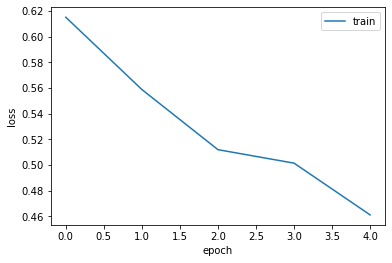

In [485]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'])
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [486]:
finetuner.model.save_weights('experiments/2019-12-23/LSTM_Chem/checkpoints/finetuned_gen' + str(GLOBAL_GENERATION) + '.hdf5')

In [487]:
# used the fine tuned weight to generate 5k of data
config['model_weight_filename'] = 'experiments/2019-12-23/LSTM_Chem/checkpoints/finetuned_gen' + str(GLOBAL_GENERATION) + '.hdf5'
modeler = LSTMChem(config, session='generate')
generator = LSTMChemGenerator(modeler)
print(config)

Loading model architecture from experiments/2019-12-23/LSTM_Chem/model_arch.json ...
Loading model checkpoint from experiments/2019-12-23/LSTM_Chem/checkpoints/finetuned_gen13.hdf5 ...
Loaded the Model.
batch_size: 512
checkpoint_dir: experiments\2019-12-23\LSTM_Chem\checkpoints/
checkpoint_mode: min
checkpoint_monitor: val_loss
checkpoint_save_best_only: false
checkpoint_save_weights_only: true
checkpoint_verbose: 1
config_file: experiments/2019-12-23/LSTM_Chem/config.json
data_filename: ./datasets/all_smiles_clean.smi
data_length: 0
exp_dir: experiments\2019-12-23\LSTM_Chem
exp_name: LSTM_Chem
finetune_batch_size: 1
finetune_data_filename: ./generations/training/gen13_training.smi
finetune_epochs: 5
model_arch_filename: experiments/2019-12-23/LSTM_Chem/model_arch.json
model_weight_filename: experiments/2019-12-23/LSTM_Chem/checkpoints/finetuned_gen13.hdf5
num_epochs: 42
optimizer: adam
sampling_temp: 0.75
seed: 71
smiles_max_length: 128
tensorboard_log_dir: experiments\2019-12-23\LST

In [488]:
sample_number = 5000
sampled_smiles = generator.sample(num=sample_number)


 11%|█         | 538/5000 [03:28<31:03,  2.39it/s]


 22%|██▏       | 1096/5000 [07:14<1:11:40,  1.10s/it]


 33%|███▎      | 1653/5000 [10:43<44:41,  1.25it/s]


 44%|████▍     | 2206/5000 [14:24<18:13,  2.55it/s]


 55%|█████▍    | 2740/5000 [17:40<24:40,  1.53it/s]


 65%|██████▌   | 3274/5000 [21:14<07:45,  3.71it/s]


 77%|███████▋  | 3827/5000 [24:49<09:29,  2.06it/s]


 88%|████████▊ | 4412/5000 [28:09<02:39,  3.68it/s]


 99%|█████████▉| 4955/5000 [31:43<00:34,  1.29it/s]


100%|██████████| 5000/5000 [32:02<00:00,  2.60it/s]


In [489]:
valid_mols = []
for smi in sampled_smiles:
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        valid_mols.append(mol)
# low validity
print('Validity: ', f'{len(valid_mols) / sample_number:.2%}')
valid_smiles = [Chem.MolToSmiles(mol) for mol in valid_mols]

# high uniqueness
print('Uniqueness: ', f'{len(set(valid_smiles)) / len(valid_smiles):.2%}')

# Of valid smiles generated, how many are truly original vs ocurring in the training data
import pandas as pd
training_data = pd.read_csv('./datasets/all_smiles_clean.smi', header=None)
training_set = set(list(training_data[0]))
original = []
for smile in list(set(valid_smiles)):
    if not smile in training_set:
        original.append(smile)
print('Originality: ', f'{len(set(original)) / len(set(valid_smiles)):.2%}')

Validity:  87.02%
Uniqueness:  26.89%
Originality:  100.00%


In [490]:
valid_smiles = list(set(valid_smiles))
len(valid_smiles)

1170

In [491]:
mols_for_next_generation = validate_mols(valid_smiles)

# Cross-Over and Mutation Part 2 (Local)

In [492]:
# Cross-Over and Mutation
mutation_rate = 0.05
total_generation = 5000
mating_pool = 50 # make sure this is smaller or equal to the population 

# generation 0
gen_population = reproduce(mols_for_next_generation, population_size, mutation_rate)
new_population_list = compute_logP_population(gen_population, mating_pool)
new_population = [mol[0] for mol in new_population_list]
Logp = [logP[1] for logP in new_population_list]
minimum_LogP = min(Logp)
maximum_LogP = max(Logp)

# print("Generation 0: \n{}".format(Logp))
print("Generation 0: Minimum, Maximum: {}, {} \n".format(minimum_LogP, maximum_LogP))

# generation 1 and above
for gen in range(1, total_generation):
    gen_population = reproduce(new_population, population_size, mutation_rate)
    new_population_list = compute_logP_population(gen_population, mating_pool)
    
    new_population = [mol[0] for mol in new_population_list]
    Logp = [logP[1] for logP in new_population_list]
    minimum_LogP = min(Logp)
    maximum_LogP = max(Logp)
    
    print("Generation {}: Minimum, Maximum: {}, {} \n".format(gen, minimum_LogP, maximum_LogP))
    
    if (min(Logp) >= 1.35 and max(Logp) <= 1.8):
        break

Generation 0: Minimum, Maximum: 1.3643, 1.7800999999999998 

Generation 1: Minimum, Maximum: 1.3614000000000008, 1.6866 



In [493]:
population_co_after_train = [Chem.MolToSmiles(mol) for mol in new_population] # Convert to smile
population_co_after_train = validate_mols(population_co_after_train) # Validate molecule
population_co_after_train = list(dict.fromkeys(population_co_after_train)) # Remove Duplicate in the list

In [494]:
new_population[:5]

In [495]:
# Append the cross-over result to the mols for export
# population_co_after_train: This is from the local cross-over
# mols_for_next_generation: This is from the generated 5k data
# mols_for_export: Combine mols_for_next_generation + population_co_after_train

mols_for_export = mols_for_next_generation + population_co_after_train
mols_crossover = population_co_after_train
mols_transfer_learning = mols_for_next_generation

In [496]:
# Change the variables from mols_for_export -> valid_smiles

# valid_smiles = list(set(mols_for_export))
# len(valid_smiles)

valid_smiles_crossover = list(set(mols_crossover))
valid_smiles_transfer_learning = list(set(mols_transfer_learning))


In [497]:
# take the valid smiles from above and run them through process 
# to add to tracking table and to generate next PyRx testing data

# valid_smiles -> mols_for_next_generation
# mols_for_next_generation = validate_mols([Chem.MolToSmiles(mol) for mol in valid_smiles])

mols_crossover = validate_mols([Chem.MolToSmiles(mol) for mol in valid_smiles_crossover])
mols_transfer_learning = validate_mols([Chem.MolToSmiles(mol) for mol in valid_smiles_transfer_learning])

# Get the master table from previous generations and append it 
master_table = pd.read_csv('./generations/master_results_table_gen' + str(GLOBAL_GENERATION-1) +'.csv',sep=',')

# dropping ALL duplicate values 
master_table.drop_duplicates(subset ="smile", keep = False, inplace = True) 

# Add to the tracking table
# new_mols_to_test = append_to_tracking_table(master_table,mols_for_next_generation, 'generated', GLOBAL_GENERATION)
# mols_for_pd = new_mols_to_test[0]
# mols_for_export = new_mols_to_test[1]


# Add cross-over molecule to the master table
new_mols_to_test_crossover = append_to_tracking_table(master_table,mols_crossover, 'genetic_algorithm', GLOBAL_GENERATION)
mols_for_pd_crossover = new_mols_to_test_crossover[0]
mols_for_export_crossover = new_mols_to_test_crossover[1]

# Add transfer learning molecule to the master table
new_mols_to_test_transfer_learning = append_to_tracking_table(master_table,mols_transfer_learning, 'generated', GLOBAL_GENERATION)
mols_for_pd_transfer_learning = new_mols_to_test_transfer_learning[0]
mols_for_export_transfer_learning = new_mols_to_test_transfer_learning[1]

# Join cross-over molecule with transfer learning
mols_for_pd = mols_for_pd_crossover.append(mols_for_pd_transfer_learning)
mols_for_export = mols_for_export_crossover + mols_for_export_transfer_learning

# Save the whole details in new table with current generations
master_table = master_table.append(mols_for_pd)
master_table = master_table.reset_index(drop=True)
master_table.to_csv(r'./generations/master_results_table_gen' + str(GLOBAL_GENERATION) + '.csv', index=False)

In [498]:
master_table.shape

(14299, 7)

In [499]:
len(mols_for_export)

1220

In [500]:
# dropping ALL duplicate values 
master_table.drop_duplicates(subset ="smile", keep = False, inplace = True) 

In [501]:
write_gen_to_sdf(mols_for_export, GLOBAL_GENERATION, 2000)
print('ok')

ok
